# Evaluating the result of imputation experiment

_Yuichiro Iwashita, Kaiserslautern, 8 February 2024_

In this notebook, we evaluate the quality of imputation using LLMs and the performance of downstream task using imputed data.

## Run evaluation

ToDo: Explain steps

## Libraries

In [83]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

## Formatting the results

In [84]:
data_dirpath = Path('../..') / 'data'
output_imputation_dirpath = data_dirpath / 'output/imputation'
output_figures_dirpath = output_imputation_dirpath / 'output/fig'
output_figures_dirpath.mkdir(parents=True, exist_ok=True)
openml_dirpath = data_dirpath / 'openml'

In [85]:
methods = [
    'meanmode',
    'knn',
    'rf',
    'llm/expert/meta-llama/Llama-2-13b-chat-hf',
    'llm/expert/meta-llama/Llama-2-70b-chat-hf',
    'llm/expert/mistralai/Mistral-7B-Instruct-v0.2',
    'llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1'
]

In [86]:
def fetch_openml_metadata():
    dataset_list_filepath = openml_dirpath / 'openml-custom-list.csv'
    dataset_list = pd.read_csv(dataset_list_filepath, header=0)
    dict = {}
    for openml_id in dataset_list['did']:
        dict[openml_id] = {}
        dataset_description_filepath = openml_dirpath / f'{openml_id}/description.txt'
        with open(dataset_description_filepath) as f:
            dataset_description = f.read()
            dataset_description_length = len(dataset_description)
            dict[openml_id]['desc_len'] = dataset_description_length
            dict[openml_id]['n_features'] = dataset_list.loc[dataset_list['did'] == openml_id, 'NumberOfFeatures'].iloc[0]
            dict[openml_id]['domain'] = dataset_list.loc[dataset_list['did'] == openml_id, 'category (manually)'].iloc[0]
            dict[openml_id]['n_instances'] = dataset_list.loc[dataset_list['did'] == openml_id, 'NumberOfInstances'].iloc[0]
            dict[openml_id]['tasks_runs'] = dataset_list.loc[dataset_list['did'] == openml_id, 'tasks_runs'].iloc[0]
    return dict

In [87]:
color_dict = {
    'meanmode': 'black',
    'knn': 'blue',
    'rf': 'green',
    'llm/expert/meta-llama/Llama-2-13b-chat-hf': 'red',
    'llm/expert/meta-llama/Llama-2-70b-chat-hf': 'orange',
    'llm/expert/mistralai/Mistral-7B-Instruct-v0.2': 'purple',
    'llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1': 'brown'
}

In [88]:
color_dict_p9 = {
    'Mean/Mode': 'black',
    '$k$-NN': 'blue',
    'Random Forest': 'green',
    'LLaMA 2 13B Chat': 'red',
    'LLaMA 2 70B Chat': 'orange',
    'Mistral 7B Instruct': 'purple',
    'Mixtral 8x7B Instruct': 'brown'
}

In [89]:
corrected_method_names = {
    'meanmode': 'Mean/Mode',
    'knn': '$k$-NN',
    'rf': 'Random Forest',
    'llm/expert/meta-llama/Llama-2-13b-chat-hf': 'LLaMA 2 13B Chat',
    'llm/expert/meta-llama/Llama-2-70b-chat-hf': 'LLaMA 2 70B Chat',
    'llm/expert/mistralai/Mistral-7B-Instruct-v0.2': 'Mistral 7B Instruct',
    'llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1': 'Mixtral 8x7B Instruct'
}

### RMSE

In [90]:
def rmse_process(df, method):
    openml_metadata = fetch_openml_metadata()
    df = df.drop(['macro_f1'], axis=1)
    df = df[df['rmse'] <= 1.0]
    df = df[df['rmse'] >= 0.0]
    df = df.dropna()
    df['desc_len'] = df['openml_id'].apply(lambda x: openml_metadata[x]['desc_len'])
    df['n_features'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_features'])
    df['domain'] = df['openml_id'].apply(lambda x: openml_metadata[x]['domain'])
    df['n_instances'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_instances'])
    df['tasks_runs'] = df['openml_id'].apply(lambda x: openml_metadata[x]['tasks_runs'])
    df['color'] = color_dict[method]
    df['method'] = method
    df['corrected_method'] = corrected_method_names[method]
    
    # Best RMSE in [meanmode, knn, rf]
    for openml_id in df['openml_id'].unique():
        best_rmse = df.loc[df['openml_id'] == openml_id, 'rmse'].min()
        df.loc[(df['openml_id'] == openml_id) & (df['rmse'] == best_rmse), 'method'] = 'Best Baseline'
    df = df[df['tasks_runs'] >= 3000]
    return df

In [91]:
rmse_results = {}
for method in methods:
    method_output_dirpath = output_imputation_dirpath / method
    method_rmse_results_filepath = method_output_dirpath / f'imputation_complete.csv'
    method_rmse_results = pd.read_csv(method_rmse_results_filepath, header=0)
    rmse_results[method] = rmse_process(method_rmse_results, method)
rmse_results['meanmode'].head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,rmse,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
3,2024-01-29 15:34:26,meanmode,6,MAR,x-box,numerical,24,0.171829,1057,17,computer vision,20000,69914,black,Mean/Mode
4,2024-01-29 15:34:26,Best Baseline,6,MAR,y-box,numerical,13,0.169215,1057,17,computer vision,20000,69914,black,Mean/Mode
5,2024-01-29 15:34:26,meanmode,6,MAR,x-bar,numerical,13,0.201238,1057,17,computer vision,20000,69914,black,Mean/Mode
6,2024-01-29 15:34:26,Best Baseline,11,MAR,left-weight,numerical,15,0.295607,1013,5,psychology,625,30115,black,Mean/Mode
7,2024-01-29 15:34:26,meanmode,11,MAR,left-distance,numerical,18,0.320139,1013,5,psychology,625,30115,black,Mean/Mode


In [92]:
rmse_summary_df = pd.concat([rmse_results[method] for method in methods])
rmse_summary_df.head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,rmse,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
3,2024-01-29 15:34:26,meanmode,6,MAR,x-box,numerical,24,0.171829,1057,17,computer vision,20000,69914,black,Mean/Mode
4,2024-01-29 15:34:26,Best Baseline,6,MAR,y-box,numerical,13,0.169215,1057,17,computer vision,20000,69914,black,Mean/Mode
5,2024-01-29 15:34:26,meanmode,6,MAR,x-bar,numerical,13,0.201238,1057,17,computer vision,20000,69914,black,Mean/Mode
6,2024-01-29 15:34:26,Best Baseline,11,MAR,left-weight,numerical,15,0.295607,1013,5,psychology,625,30115,black,Mean/Mode
7,2024-01-29 15:34:26,meanmode,11,MAR,left-distance,numerical,18,0.320139,1013,5,psychology,625,30115,black,Mean/Mode


In [93]:
rmse_summary_llm_df = rmse_summary_df[rmse_summary_df['method'].str.contains('llm')]
rmse_summary_llm_df.head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,rmse,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
4,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,6,MAR,y-box,numerical,13,0.337680,1057,17,computer vision,20000,69914,red,LLaMA 2 13B Chat
5,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,6,MAR,x-bar,numerical,13,0.313691,1057,17,computer vision,20000,69914,red,LLaMA 2 13B Chat
6,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,11,MAR,left-weight,numerical,15,0.308727,1013,5,psychology,625,30115,red,LLaMA 2 13B Chat
7,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,11,MAR,left-distance,numerical,18,0.323115,1013,5,psychology,625,30115,red,LLaMA 2 13B Chat
13,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,14,MAR,att11,numerical,22,0.503916,1203,77,computer vision,2000,38439,red,LLaMA 2 13B Chat


### F1

In [94]:
def f1_process(df, method):
    openml_metadata = fetch_openml_metadata()
    df = df.drop(['rmse'], axis=1)
    df = df[(df['macro_f1'] <= 1.0) & (df['macro_f1'] >= 0.0)]
    df = df.dropna()
    df['desc_len'] = df['openml_id'].apply(lambda x: openml_metadata[x]['desc_len'])
    df['n_features'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_features'])
    df['domain'] = df['openml_id'].apply(lambda x: openml_metadata[x]['domain'])
    df['n_instances'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_instances'])
    df['tasks_runs'] = df['openml_id'].apply(lambda x: openml_metadata[x]['tasks_runs'])
    df['color'] = color_dict[method]
    df['method'] = method
    df['corrected_method'] = corrected_method_names[method]
    # remove item which tasks_runs is less than 3000
    df = df[df['tasks_runs'] >= 3000]
    return df

In [95]:
f1_results = {}
for method in methods:
    method_output_dirpath = output_imputation_dirpath / method
    method_f1_results_filepath = method_output_dirpath / f'imputation_complete.csv'
    method_f1_results = pd.read_csv(method_f1_results_filepath, header=0)
    f1_results[method] = f1_process(method_f1_results, method)
f1_results['meanmode'].head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
0,2024-01-29 15:34:26,meanmode,3,MAR,hdchk,categorical,20,1.000000,3178,37,board game,3196,274238,black,Mean/Mode
1,2024-01-29 15:34:26,meanmode,3,MAR,skrxp,categorical,14,1.000000,3178,37,board game,3196,274238,black,Mean/Mode
2,2024-01-29 15:34:26,meanmode,3,MAR,wtoeg,categorical,16,0.683333,3178,37,board game,3196,274238,black,Mean/Mode
24,2024-01-29 15:34:26,meanmode,23,MAR,Wifes_education,categorical,20,0.465716,2434,10,social sciences,1473,24352,black,Mean/Mode
25,2024-01-29 15:34:26,meanmode,23,MAR,Wifes_now_working%3F,categorical,14,0.600000,2434,10,social sciences,1473,24352,black,Mean/Mode


In [96]:
f1_summary_df = pd.concat([f1_results[method] for method in methods])
f1_summary_df.head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
0,2024-01-29 15:34:26,meanmode,3,MAR,hdchk,categorical,20,1.000000,3178,37,board game,3196,274238,black,Mean/Mode
1,2024-01-29 15:34:26,meanmode,3,MAR,skrxp,categorical,14,1.000000,3178,37,board game,3196,274238,black,Mean/Mode
2,2024-01-29 15:34:26,meanmode,3,MAR,wtoeg,categorical,16,0.683333,3178,37,board game,3196,274238,black,Mean/Mode
24,2024-01-29 15:34:26,meanmode,23,MAR,Wifes_education,categorical,20,0.465716,2434,10,social sciences,1473,24352,black,Mean/Mode
25,2024-01-29 15:34:26,meanmode,23,MAR,Wifes_now_working%3F,categorical,14,0.600000,2434,10,social sciences,1473,24352,black,Mean/Mode


In [97]:
f1_summary_llm_df = f1_summary_df[f1_summary_df['method'].str.contains('llm')]
f1_summary_llm_df.head()

,timestamp,method,openml_id,missingness,missing_column_name,missing_column_type,n_missing_values,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,corrected_method
0,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,3,MAR,hdchk,categorical,20,0.142857,3178,37,board game,3196,274238,red,LLaMA 2 13B Chat
1,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,3,MAR,skrxp,categorical,14,0.296296,3178,37,board game,3196,274238,red,LLaMA 2 13B Chat
2,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,3,MAR,wtoeg,categorical,16,0.214286,3178,37,board game,3196,274238,red,LLaMA 2 13B Chat
24,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,23,MAR,Wifes_education,categorical,20,0.483529,2434,10,social sciences,1473,24352,red,LLaMA 2 13B Chat
25,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,23,MAR,Wifes_now_working%3F,categorical,14,0.236111,2434,10,social sciences,1473,24352,red,LLaMA 2 13B Chat


### Downstream

Downstream benchmark

Train on incomplete, test on incomplete

In [98]:
downstream_baseline_df_filepath = output_imputation_dirpath / 'baseline/train_incomplete/downstream_complete.csv'
downstream_baseline_df = pd.read_csv(downstream_baseline_df_filepath, header=0)
downstream_baseline_df = downstream_baseline_df.drop(['timestamp'], axis=1)
downstream_baseline_df['method'] = 'Baseline'
downstream_baseline_df['method_id'] = -1
downstream_baseline_df = downstream_baseline_df.groupby(['method', 'method_id', 'openml_id', 'missingness']).mean().reset_index()
downstream_baseline_df.head()

,method,method_id,openml_id,missingness,accuracy,macro_f1
0,Baseline,-1,3,MAR,0.984375,0.984320
1,Baseline,-1,6,MAR,0.957250,0.956840
2,Baseline,-1,11,MAR,0.864000,0.602605
3,Baseline,-1,12,MAR,0.960000,0.958754
4,Baseline,-1,14,MAR,0.837500,0.830736


In [99]:
def downstream_process(df, method):
    openml_metadata = fetch_openml_metadata()
    df['desc_len'] = df['openml_id'].apply(lambda x: openml_metadata[x]['desc_len'])
    df['n_features'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_features'])
    df['domain'] = df['openml_id'].apply(lambda x: openml_metadata[x]['domain'])
    df['n_instances'] = df['openml_id'].apply(lambda x: openml_metadata[x]['n_instances'])
    df['tasks_runs'] = df['openml_id'].apply(lambda x: openml_metadata[x]['tasks_runs'])
    df['color'] = color_dict[method]
    
    for openml_id in df['openml_id'].unique():
        baseline_accuracy = downstream_baseline_df.loc[downstream_baseline_df['openml_id'] == openml_id, 'accuracy'].values[0]
        # baseline_f1 = downstream_baseline_df.loc[downstream_baseline_df['openml_id'] == openml_id, 'f1'].values[0]
    
        df.loc[df['openml_id'] == openml_id, 'baseline_accuracy'] = baseline_accuracy
        # df.loc[df['openml_id'] == openml_id, 'baseline_f1'] = baseline_f1
        
        df.loc[df['openml_id'] == openml_id, 'accuracy_improvement'] = (df.loc[df['openml_id'] == openml_id, 'accuracy'] - baseline_accuracy)  / baseline_accuracy * 100
        # df.loc[df['openml_id'] == openml_id, 'f1_improvement'] = (df.loc[df['openml_id'] == openml_id, 'macro_f1'] - baseline_f1)  / baseline_f1 * 100
    
    df['method'] = method
    df['corrected_method'] = corrected_method_names[method]
    df = df[df['tasks_runs'] >= 3000]
    return df

In [100]:
downstream_results = {}
for method in methods:
    method_output_dirpath = output_imputation_dirpath / method
    method_downstream_results_filepath = method_output_dirpath / f'downstream_complete.csv'
    method_downstream_results = pd.read_csv(method_downstream_results_filepath, header=0)
    downstream_results[method] = downstream_process(method_downstream_results, method)
downstream_results['meanmode'].head()

,timestamp,method,openml_id,missingness,accuracy,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,baseline_accuracy,accuracy_improvement,corrected_method
0,2024-01-29 15:34:26,meanmode,3,MAR,0.98125,0.981190,3178,37,board game,3196,274238,black,0.984375,-0.317460,Mean/Mode
1,2024-01-29 15:34:26,meanmode,6,MAR,0.96200,0.961736,1057,17,computer vision,20000,69914,black,0.957250,0.496213,Mean/Mode
2,2024-01-29 15:34:26,meanmode,11,MAR,0.81600,0.588394,1013,5,psychology,625,30115,black,0.864000,-5.555556,Mean/Mode
3,2024-01-29 15:34:26,meanmode,12,MAR,0.96500,0.963787,1211,217,computer vision,2000,37793,black,0.960000,0.520833,Mean/Mode
4,2024-01-29 15:34:26,meanmode,14,MAR,0.85500,0.850010,1203,77,computer vision,2000,38439,black,0.837500,2.089552,Mean/Mode


In [101]:
downstream_summary_df = pd.concat([downstream_results[method] for method in methods])
downstream_summary_df.head()

,timestamp,method,openml_id,missingness,accuracy,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,baseline_accuracy,accuracy_improvement,corrected_method
0,2024-01-29 15:34:26,meanmode,3,MAR,0.98125,0.981190,3178,37,board game,3196,274238,black,0.984375,-0.317460,Mean/Mode
1,2024-01-29 15:34:26,meanmode,6,MAR,0.96200,0.961736,1057,17,computer vision,20000,69914,black,0.957250,0.496213,Mean/Mode
2,2024-01-29 15:34:26,meanmode,11,MAR,0.81600,0.588394,1013,5,psychology,625,30115,black,0.864000,-5.555556,Mean/Mode
3,2024-01-29 15:34:26,meanmode,12,MAR,0.96500,0.963787,1211,217,computer vision,2000,37793,black,0.960000,0.520833,Mean/Mode
4,2024-01-29 15:34:26,meanmode,14,MAR,0.85500,0.850010,1203,77,computer vision,2000,38439,black,0.837500,2.089552,Mean/Mode


In [102]:
downstream_summary_llm_df = downstream_summary_df[downstream_summary_df['method'].str.contains('llm')]
downstream_summary_llm_df.head()

,timestamp,method,openml_id,missingness,accuracy,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,baseline_accuracy,accuracy_improvement,corrected_method
0,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,3,MAR,0.984375,0.984320,3178,37,board game,3196,274238,red,0.984375,0.000000,LLaMA 2 13B Chat
1,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,6,MAR,0.960500,0.960116,1057,17,computer vision,20000,69914,red,0.957250,0.339514,LLaMA 2 13B Chat
2,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,11,MAR,0.840000,0.597978,1013,5,psychology,625,30115,red,0.864000,-2.777778,LLaMA 2 13B Chat
3,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,12,MAR,0.965000,0.963787,1211,217,computer vision,2000,37793,red,0.960000,0.520833,LLaMA 2 13B Chat
4,2024-01-29 04:57:59,llm/expert/meta-llama/Llama-2-13b-chat-hf,14,MAR,0.847500,0.842893,1203,77,computer vision,2000,38439,red,0.837500,1.194030,LLaMA 2 13B Chat


## Visualize

In [103]:
# count number of duplicates in desc_len
for method in methods:
    print(f'{method}: {downstream_results[method].duplicated(subset="desc_len").sum()}')

meanmode: 1
knn: 1
rf: 1
llm/expert/meta-llama/Llama-2-13b-chat-hf: 1
llm/expert/meta-llama/Llama-2-70b-chat-hf: 1
llm/expert/mistralai/Mistral-7B-Instruct-v0.2: 1
llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1: 1


### NRMSE

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_rmse_desc_len.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Us

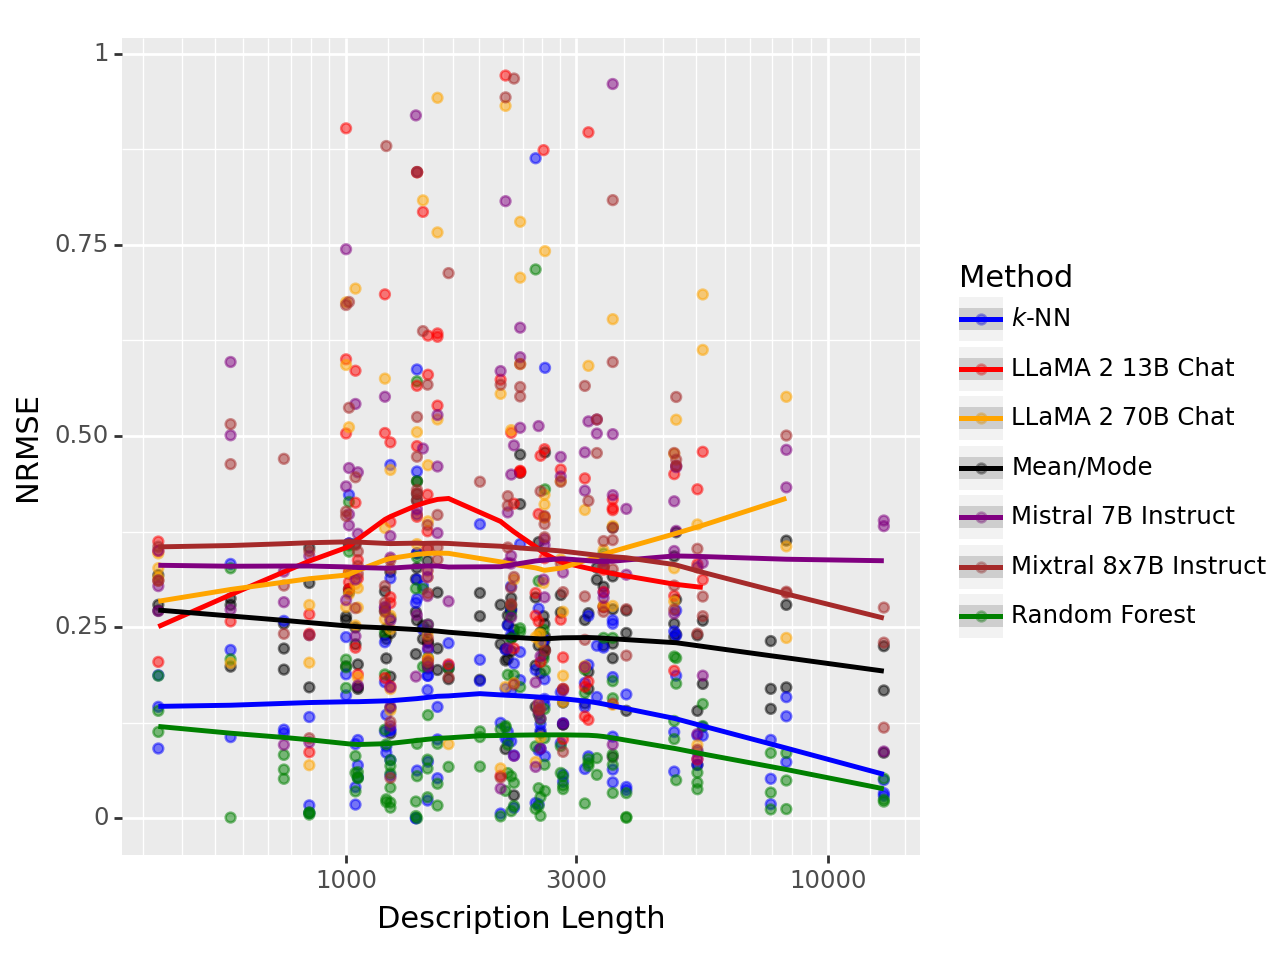

In [104]:
ggplt = (p9.ggplot(data=rmse_summary_df, mapping=p9.aes(x='desc_len', y='rmse', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth() 
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='NRMSE', color='Method')
            + p9.scale_color_manual(values=color_dict_p9)
        )
ggplt.save(output_figures_dirpath / 'all_rmse_desc_len.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_rmse_desc_len.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Us

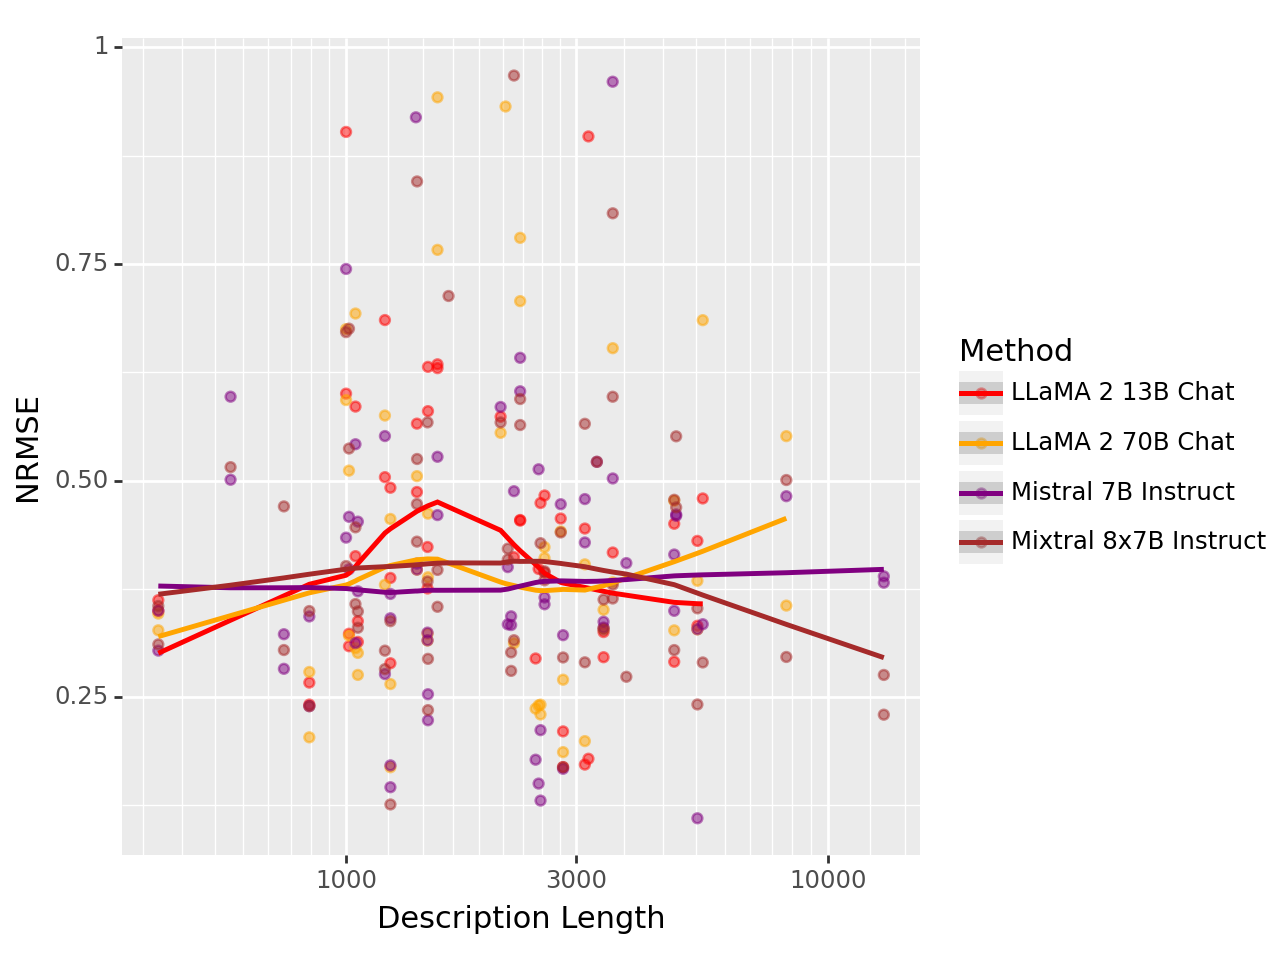

In [105]:
ggplt = (p9.ggplot(data=rmse_summary_llm_df, mapping=p9.aes(x='desc_len', y='rmse', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth() 
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='NRMSE', color='Method')
            + p9.scale_color_manual(values=color_dict_p9)
        )
ggplt.save(output_figures_dirpath / 'llm_rmse_desc_len.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_rmse_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/

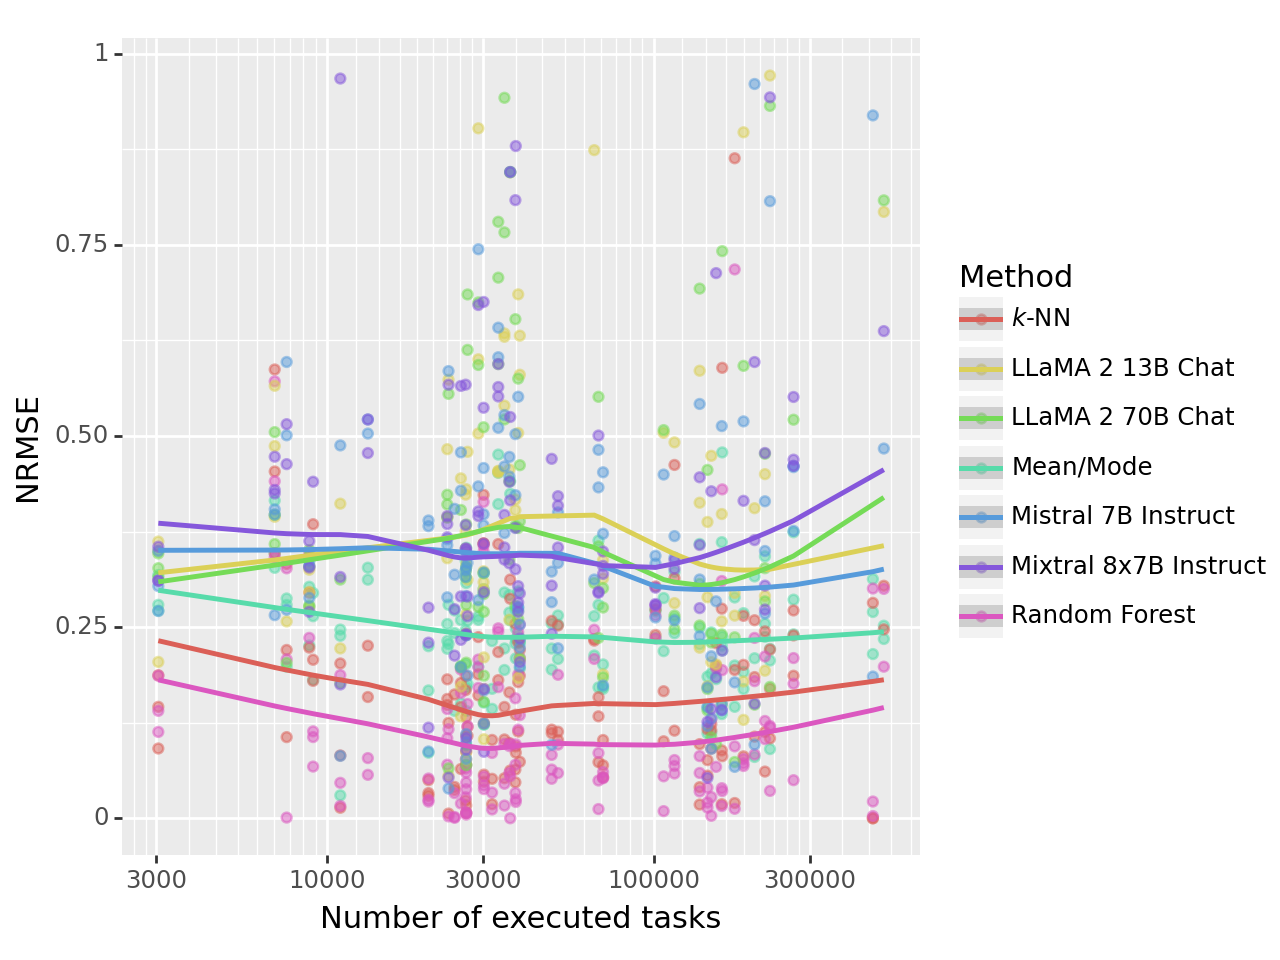

In [106]:
ggplt = (p9.ggplot(data=rmse_summary_df, mapping=p9.aes(x='tasks_runs', y='rmse', color='corrected_method'))
        + p9.geom_point(alpha=0.5)
        + p9.geom_smooth()
        + p9.scale_x_log10()
        + p9.labs(x='Number of executed tasks', y='NRMSE', color='Method')
      )
ggplt.save(output_figures_dirpath / 'all_rmse_tasks_runs.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_rmse_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/

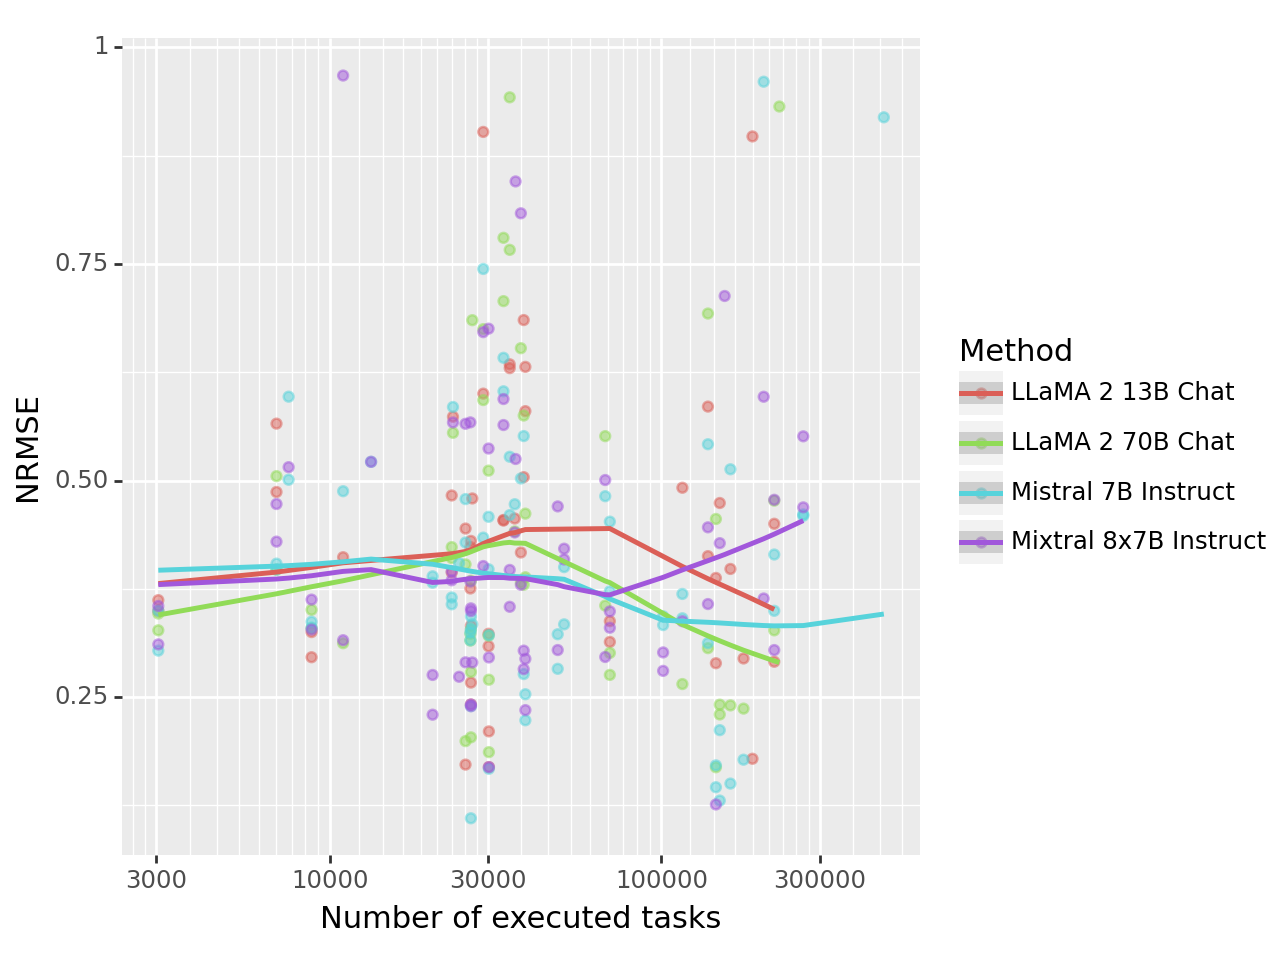

In [107]:
ggplt = (p9.ggplot(data=rmse_summary_llm_df, mapping=p9.aes(x='tasks_runs', y='rmse', color='corrected_method'))
        + p9.geom_point(alpha=0.5)
        + p9.geom_smooth()
        + p9.scale_x_log10()
        + p9.labs(x='Number of executed tasks', y='NRMSE', color='Method')
      )
ggplt.save(output_figures_dirpath / 'llm_rmse_tasks_runs.pdf')
ggplt.draw()

Density graph of NRMSE

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for method in methods:
    label = corrected_method_names[method]
    if method.startswith('llm'):
        sns.kdeplot(rmse_results[method]['rmse'], ax=ax, label=label, color=color_dict[method], fill=True)
    else:
        sns.kdeplot(rmse_results[method]['rmse'], ax=ax, label=label, color=color_dict[method], fill=True, alpha=0.05)
ax.legend()
ax.set_xlabel('NRMSE')
ax.set_ylabel('Density')
ax.set_xlim(0, 1.0)

(0.0, 1.0)

### $F_1$ score

Relationship between the description length and $F_1$ score

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_f1_desc_len.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/User

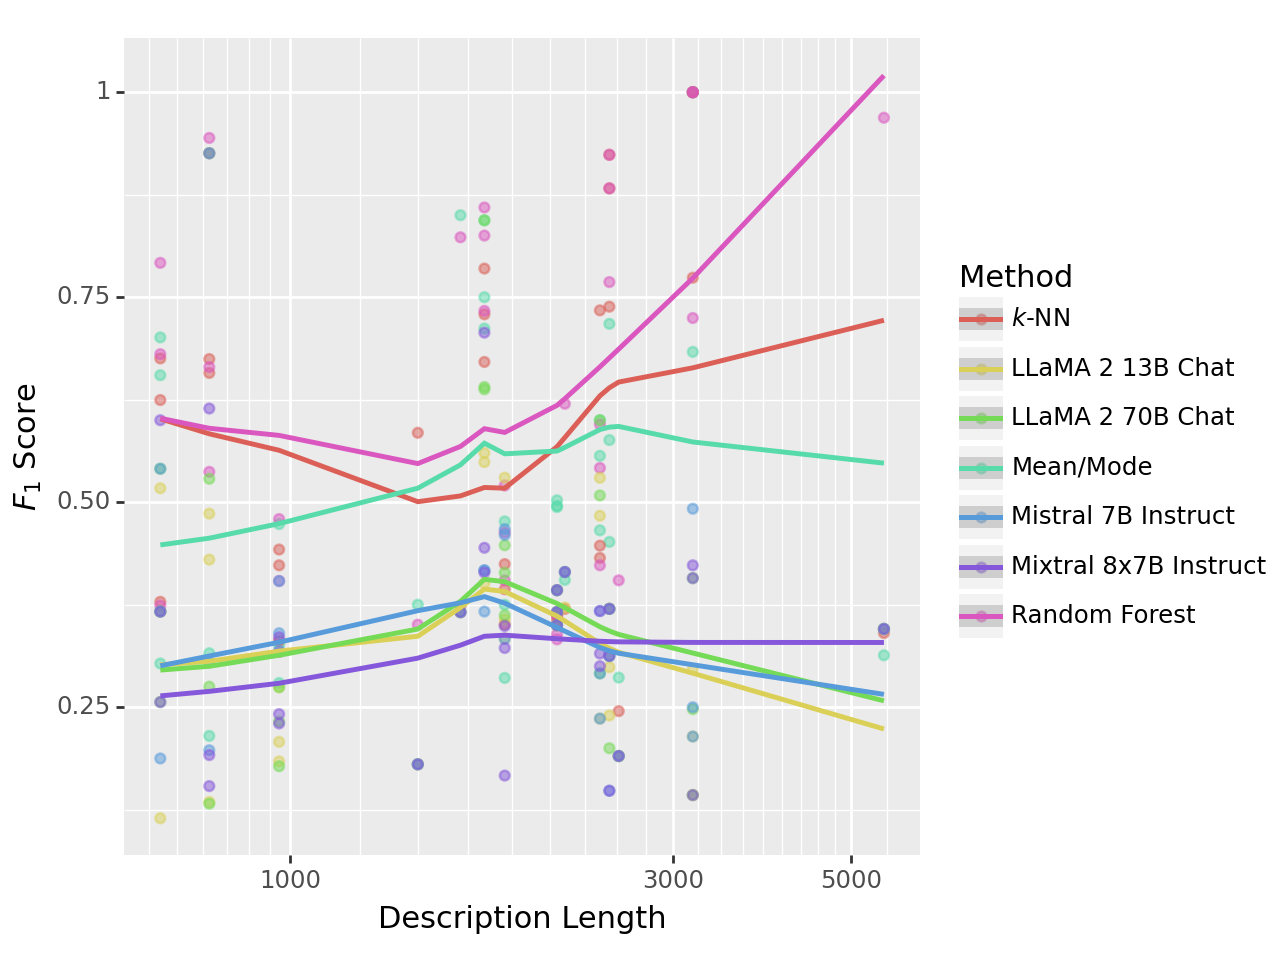

In [109]:
ggplt = (p9.ggplot(data=f1_summary_df, mapping=p9.aes(x='desc_len', y='macro_f1', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='$F_1$ Score', color='Method')
        )
ggplt.save(output_figures_dirpath / 'all_f1_desc_len.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_f1_desc_len.pdf


/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence inter

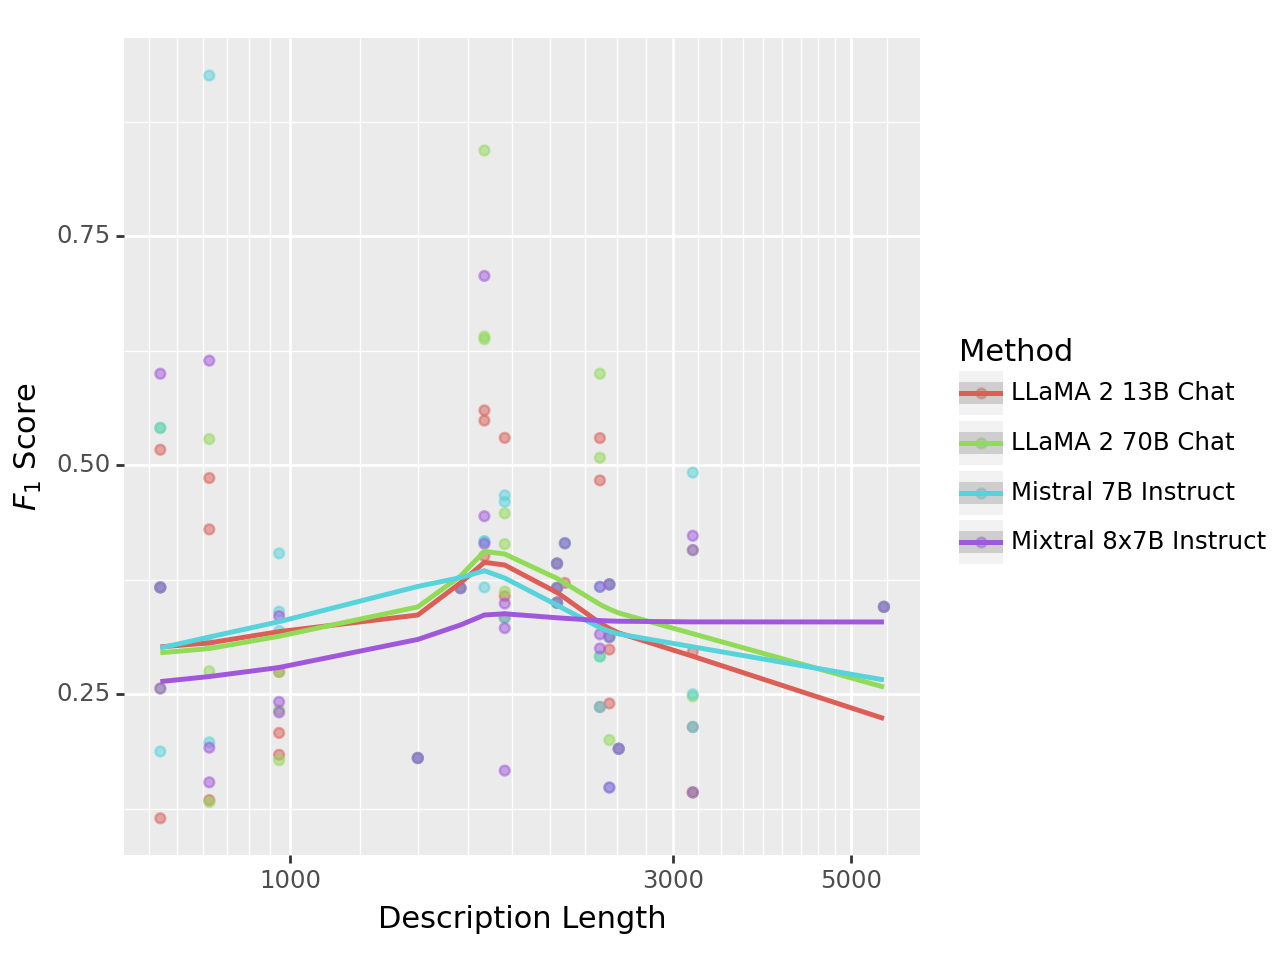

In [110]:
ggplt = (p9.ggplot(data=f1_summary_llm_df, mapping=p9.aes(x='desc_len', y='macro_f1', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='$F_1$ Score', color='Method')
        )
ggplt.save(output_figures_dirpath / 'llm_f1_desc_len.pdf')
ggplt.draw()

Relationship between the number of executed tasks and $F_1$ score

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_f1_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Us

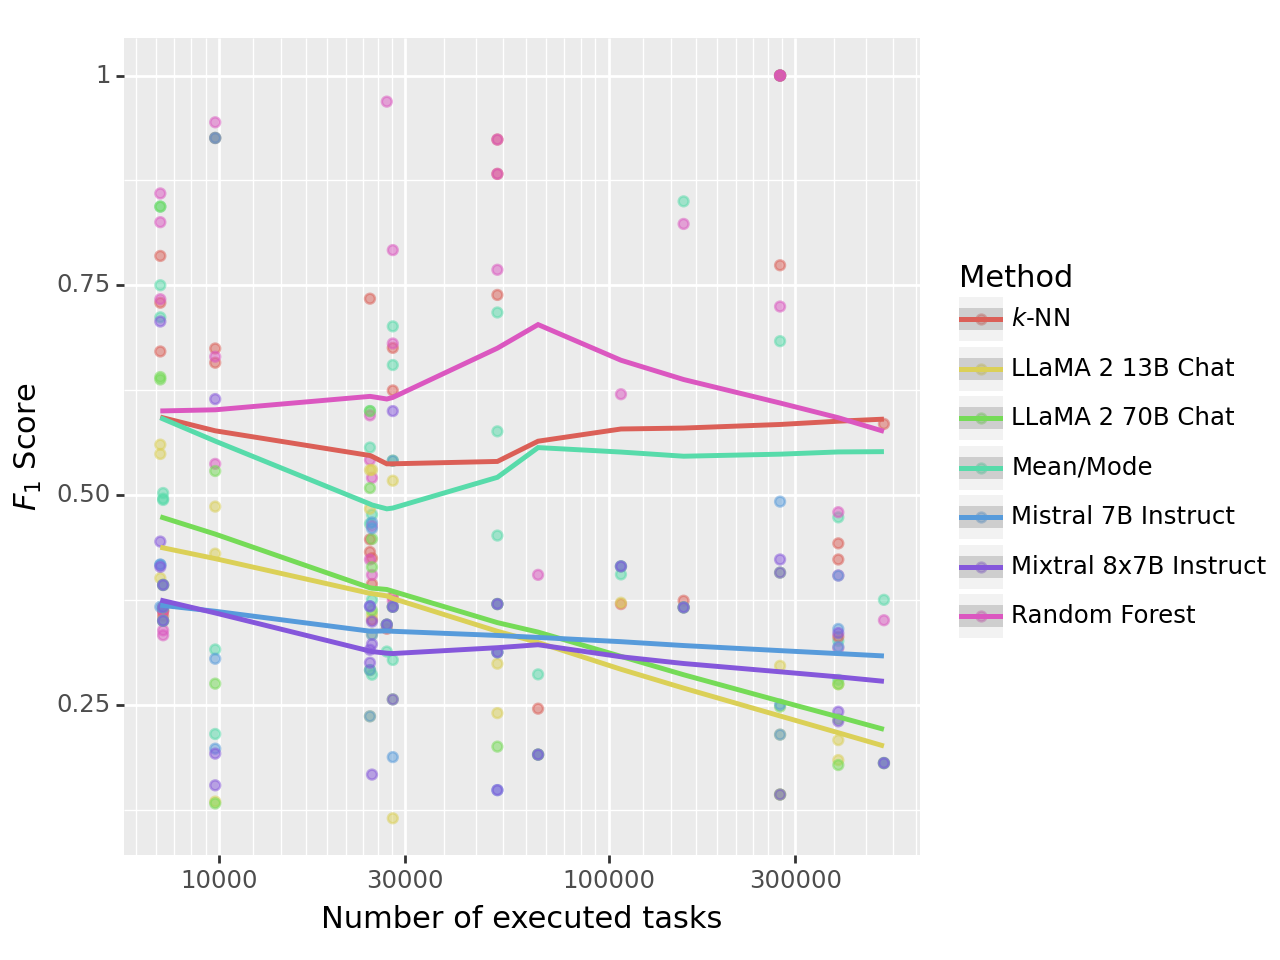

In [111]:
ggplt = (p9.ggplot(data=f1_summary_df, mapping=p9.aes(x='tasks_runs', y='macro_f1', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Number of executed tasks', y='$F_1$ Score', color='Method')
        )
ggplt.save(output_figures_dirpath / 'all_f1_tasks_runs.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_f1_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Us

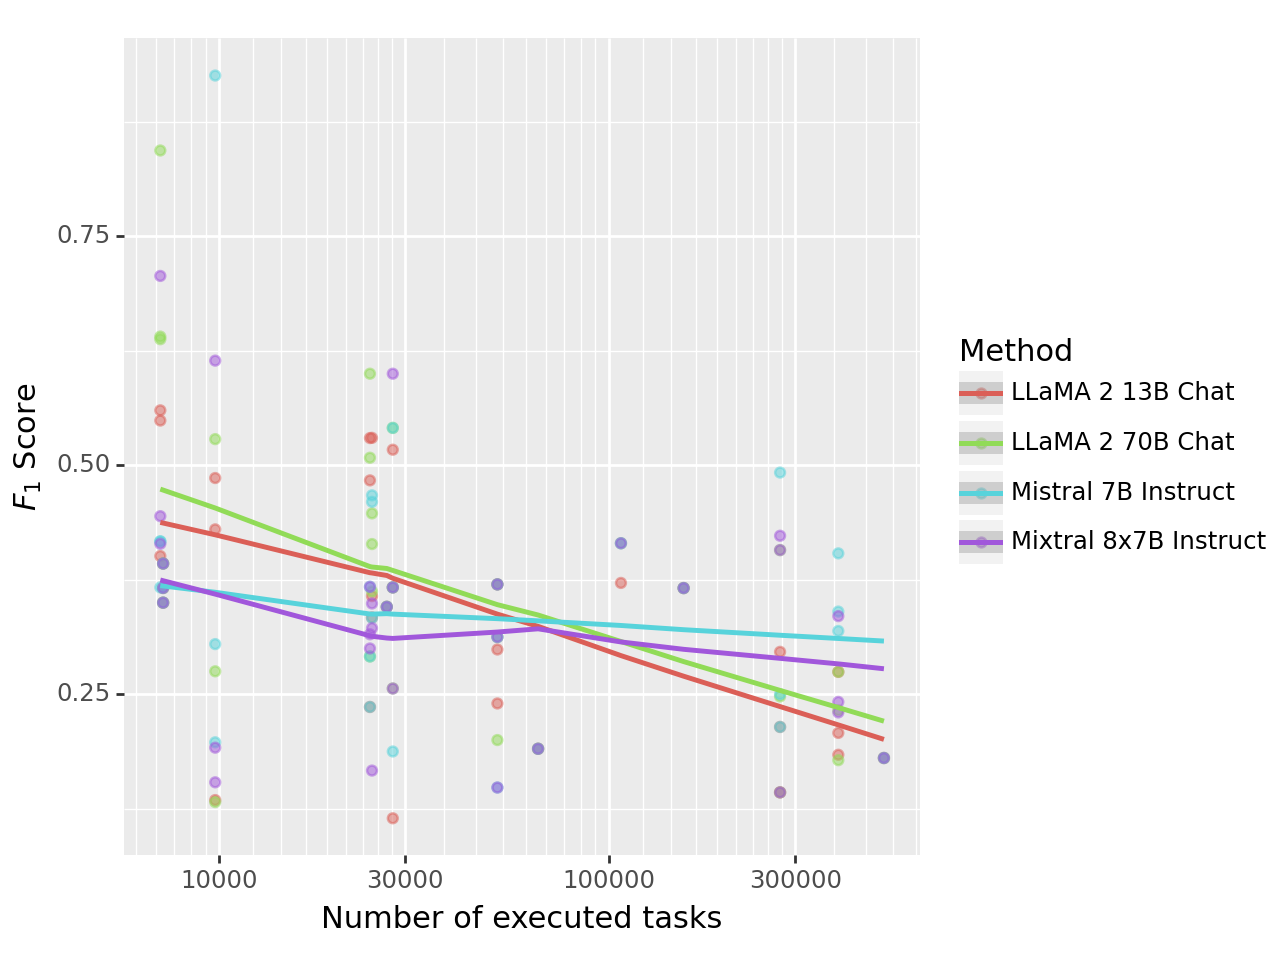

In [112]:
ggplt = (p9.ggplot(data=f1_summary_llm_df, mapping=p9.aes(x='tasks_runs', y='macro_f1', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Number of executed tasks', y='$F_1$ Score', color='Method')
        )
ggplt.save(output_figures_dirpath / 'llm_f1_tasks_runs.pdf')
ggplt.draw()

Density graph of $F_1$ score

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for method in methods:
    label = corrected_method_names[method]
    if method.startswith('llm'):
        sns.kdeplot(f1_results[method]['macro_f1'], ax=ax, label=label, color=color_dict[method], fill=True)
    else:
        sns.kdeplot(f1_results[method]['macro_f1'], ax=ax, label=label, color=color_dict[method], fill=True, alpha=0.05)
ax.legend()
ax.set_xlabel('$F_1$ Score')
ax.set_ylabel('Density')
ax.set_xlim(0, 1.0)
fig.show()

/var/folders/mr/qc9n5qqn4jjgn6jh4mpcfsgm0000gn/T/ipykernel_38631/72141346.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


### Downstream

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_downstream_desc_len.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothing

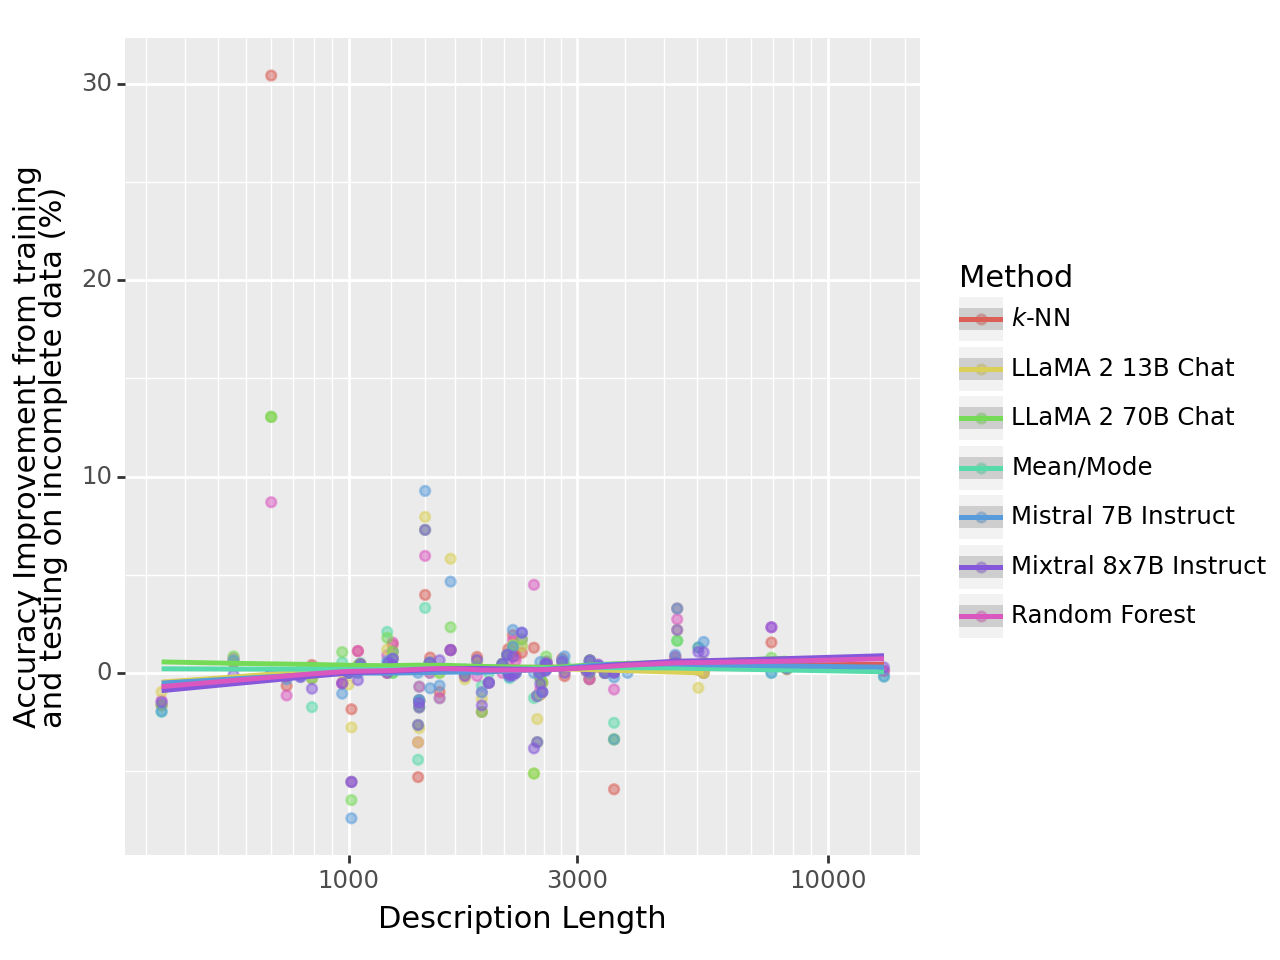

In [114]:
ggplt = (p9.ggplot(data=downstream_summary_df, mapping=p9.aes(x='desc_len', y='accuracy_improvement', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='Accuracy Improvement from training\nand testing on incomplete data (%)', color='Method')
        )
ggplt.save(output_figures_dirpath / 'all_downstream_desc_len.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_downstream_desc_len.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothing

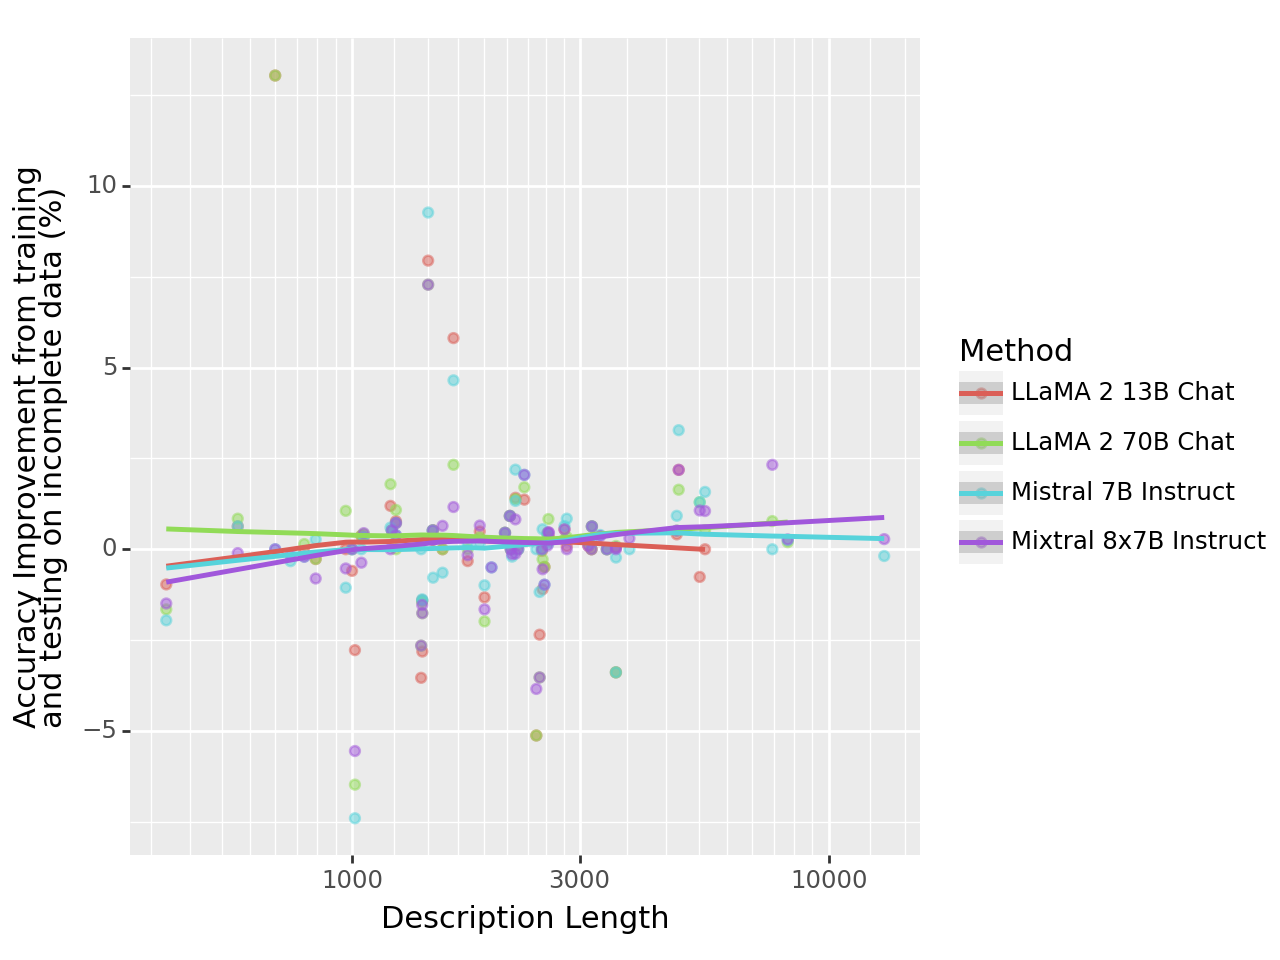

In [115]:
ggplt = (p9.ggplot(data=downstream_summary_llm_df, mapping=p9.aes(x='desc_len', y='accuracy_improvement', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Description Length', y='Accuracy Improvement from training\nand testing on incomplete data (%)', color='Method')
        )
ggplt.save(output_figures_dirpath / 'llm_downstream_desc_len.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/all_downstream_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothi

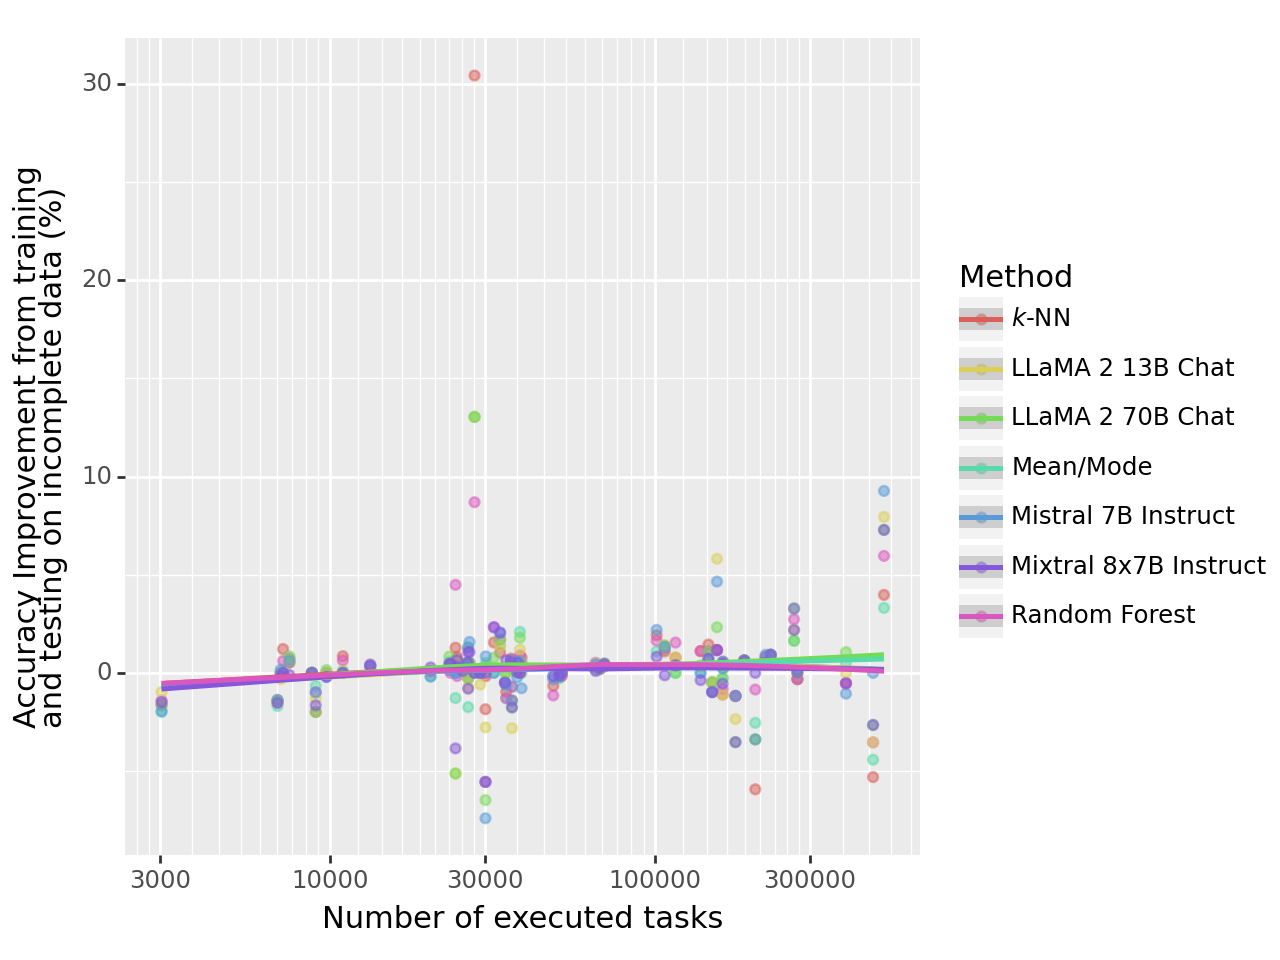

In [116]:
ggplt = (p9.ggplot(data=downstream_summary_df, mapping=p9.aes(x='tasks_runs', y='accuracy_improvement', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Number of executed tasks', y='Accuracy Improvement from training\nand testing on incomplete data (%)', color='Method')
        )
ggplt.save(output_figures_dirpath / 'all_downstream_tasks_runs.pdf')
ggplt.draw()

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_downstream_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothi

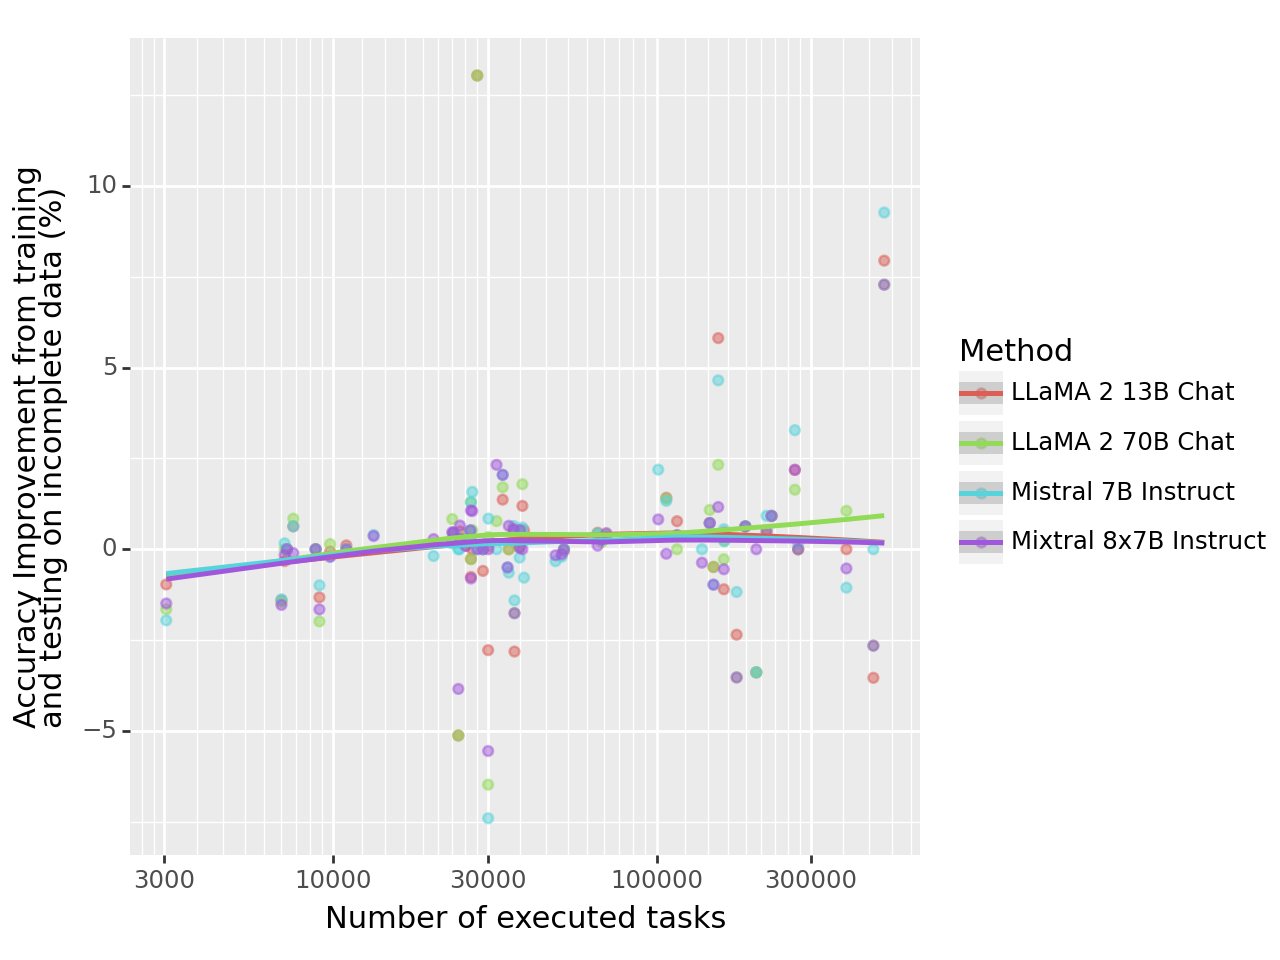

In [117]:
ggplt = (p9.ggplot(data=downstream_summary_llm_df, mapping=p9.aes(x='tasks_runs', y='accuracy_improvement', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Number of executed tasks', y='Accuracy Improvement from training\nand testing on incomplete data (%)', color='Method')
        )
ggplt.save(output_figures_dirpath / 'llm_downstream_tasks_runs.pdf')
ggplt.draw()

In [118]:
# Density plot of accuracy improvement
# x-axis: accuracy improvement
# y-axis: density

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for method in methods:
    label = corrected_method_names[method]
    if method.startswith('llm'):
        sns.kdeplot(downstream_results[method]['accuracy_improvement'], ax=ax, label=label, color=color_dict[method], fill=True)
    else:
        sns.kdeplot(downstream_results[method]['accuracy_improvement'], ax=ax, label=label, color=color_dict[method], fill=True, alpha=0.05)
ax.legend()
ax.set_xlabel('Accuracy improvement from baseline (%)')
ax.set_ylabel('Density')
ax.set_xlim(-5, 5)

(-5.0, 5.0)

In [119]:
domains = [
  'medicine',
  'biology',
  'economics',
  'engineering',
  'social sciences',
  'business',
  'psychology',
  'physics and chemistry',
  'computer vision',
  'environment',
  'natural language processing',
  'board game',
  'computer science'
]

/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../../data/output/imputation/output/fig/llm_downstream_tasks_runs.pdf
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/iwashita/Documents/research/projects/medical/pj-yuichiro/dev/llms-for-quantitative-knowledge-retrieval/.venv/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothi

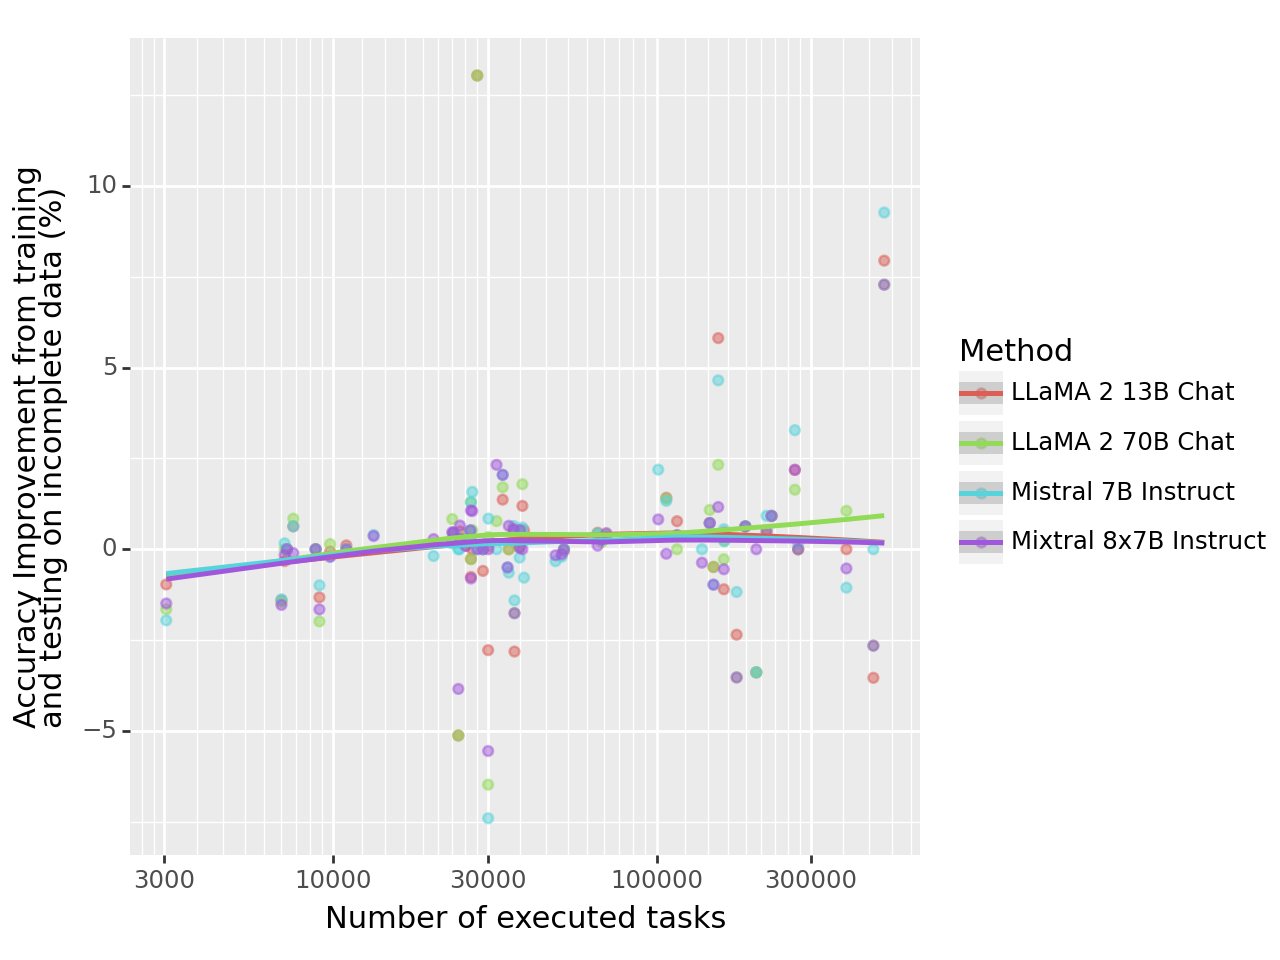

In [120]:
ggplt = (p9.ggplot(data=downstream_summary_llm_df, mapping=p9.aes(x='tasks_runs', y='accuracy_improvement', color='corrected_method'))
            + p9.geom_point(alpha=0.5)
            + p9.geom_smooth()
            + p9.scale_x_log10()
            + p9.labs(x='Number of executed tasks', y='Accuracy Improvement from training\nand testing on incomplete data (%)', color='Method')
        )
ggplt.save(output_figures_dirpath / 'llm_downstream_tasks_runs.pdf')
ggplt.draw()

In [121]:
downstream_domain_df = pd.concat([downstream_results[method] for method in methods], axis=0)
downstream_domain_df

,timestamp,method,openml_id,missingness,accuracy,macro_f1,desc_len,n_features,domain,n_instances,tasks_runs,color,baseline_accuracy,accuracy_improvement,corrected_method
0,2024-01-29 15:34:26,meanmode,3,MAR,0.981250,0.981190,3178,37,board game,3196,274238,black,0.984375,-0.317460,Mean/Mode
1,2024-01-29 15:34:26,meanmode,6,MAR,0.962000,0.961736,1057,17,computer vision,20000,69914,black,0.957250,0.496213,Mean/Mode
2,2024-01-29 15:34:26,meanmode,11,MAR,0.816000,0.588394,1013,5,psychology,625,30115,black,0.864000,-5.555556,Mean/Mode
3,2024-01-29 15:34:26,meanmode,12,MAR,0.965000,0.963787,1211,217,computer vision,2000,37793,black,0.960000,0.520833,Mean/Mode
4,2024-01-29 15:34:26,meanmode,14,MAR,0.855000,0.850010,1203,77,computer vision,2000,38439,black,0.837500,2.089552,Mean/Mode
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2024-01-29 00:58:33,llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1,40983,MAR,0.971074,0.833333,2230,6,environment,4839,10966,brown,0.971074,0.000000,Mixtral 8x7B Instruct
56,2024-01-29 00:58:33,llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1,40984,MAR,0.961039,0.964480,2092,20,computer vision,2310,23519,brown,0.956710,0.452489,Mixtral 8x7B Instruct
57,2024-01-29 00:58:33,llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1,40994,MAR,0.907407,0.475728,3423,21,environment,540,8809,brown,0.907407,0.000000,Mixtral 8x7B Instruct
58,2024-01-29 00:58:33,llm/expert/mistralai/Mixtral-8x7B-Instruct-v0.1,41027,MAR,0.780567,0.715752,1402,7,board game,44819,6905,brown,0.792726,-1.533915,Mixtral 8x7B Instruct
